# 1. Explore `.pt` files

In [1]:
import torch

# Example tensor
tensor = torch.randn(2, 3)  # Create a random tensor

# Save tensor
torch.save(tensor, 'example_tensor.pt')

# Example model
model = torch.nn.Linear(2, 3)  # A simple linear model
torch.save(model.state_dict(), 'model_weights.pt')  # Save model's state dictionary

In [3]:
import torch

# Load tensor
loaded_tensor = torch.load('example_tensor.pt')
print(loaded_tensor)

# Load model weights
model = torch.nn.Linear(2, 3)  # Recreate the model structure
loaded_weight = torch.load('model_weights.pt')
print(loaded_weight)
model.load_state_dict(loaded_weight)  # Load the saved state dictionary

tensor([[ 0.6278,  0.0057, -0.3438],
        [-0.4754, -0.0709, -0.9453]])
OrderedDict([('weight', tensor([[ 0.0971,  0.3330],
        [-0.2372, -0.3228],
        [-0.0881, -0.3040]])), ('bias', tensor([-0.5800, -0.1152, -0.2165]))])


<All keys matched successfully>

In [10]:
import torch

# Path to the .pt file
file_path = '../selected_data/mmlu/dolly_influence_score.pt'

# Load the file
loaded_data = torch.load(file_path)

# Check if the loaded data is a dictionary and print its contents
if isinstance(loaded_data, dict):
    for key, value in loaded_data.items():
        print(f"Key: {key}, Value: {value}")
else:
    print("Loaded data is not a dictionary.")
    print(loaded_data)
    print(type(loaded_data), loaded_data.shape)

Loaded data is not a dictionary.
tensor([0.0187, 0.0111, 0.0055,  ..., 0.0070, 0.0224, 0.0071], device='cuda:0')
<class 'torch.Tensor'> torch.Size([15011])


In [11]:
import torch


file_path = '../grads/TinyLlama-1.1B-p0.05-lora-seed3-fsdp/dolly-ckpt422-adam/dim8192/all_orig.pt'
loaded_data = torch.load(file_path)

if isinstance(loaded_data, dict):
    print("State dict size: ", len(loaded_data))
else:
    print("Loaded data is not a dictionary.")
    print(type(loaded_data), loaded_data.shape)

# all_orig.pt is a 2D tensor of shape: 15011 * 8192; It's not a state dict that contains other string information!

Loaded data is not a dictionary.
<class 'torch.Tensor'> torch.Size([15011, 8192])


## 1.2 Extract the most/least influential training point for each subtask

In [5]:
import torch


tsr = torch.tensor([1,2,3,4,5])
print(5 in tsr)

True


In [2]:
import json
import torch
import os
import copy

ref_model = "TinyLlama-1.1B-p1.0-lora-seed3-fsdp-dollyonly"
name_list = ["most_influential", "least_influential"]
trainset_list = ["summarization", "brainstorming", "closed_qa", "creative_writing", "information_extraction", "classification", "open_qa", "general_qa"]

data_dir = "../data"
mmlu_data_dir = os.path.join(data_dir, "eval", "mmlu")
subtask_list = sorted(
    [
        f.split("_test.csv")[0]
        for f in os.listdir(os.path.join(mmlu_data_dir, "test"))
        if "_test.csv" in f
    ]
)
assert len(subtask_list) == 57


for name in name_list:
    for trainset in trainset_list:
        jsonl_path = f"../data/train/processed/dolly/dolly_data_{trainset}.jsonl"
        inf_score_path = f"../{name}/{ref_model}/mmlu/{trainset}_influence_score.pt"
        idx_path = f"../{name}/{ref_model}/mmlu/{trainset}_{name}_indices.pt"

        inf_scores = torch.load(inf_score_path)
        assert inf_scores.shape == torch.Size([57])
        inf_scores = inf_scores.tolist()

        indices = torch.load(idx_path)
        assert indices.shape == torch.Size([57])
        indices = indices.tolist()

        final_json_list = []
        with open(jsonl_path, 'r') as f:
            lines = f.readlines()
        for line in lines:
            jsondict = json.loads(line)
            final_json_list.append(jsondict)

        final = []
        for idx, score, subtask in zip(indices, inf_scores, subtask_list):
            copied_dict = copy.deepcopy(final_json_list[idx])

            copied_dict["subtask"] = subtask
            copied_dict["inf_score"] = score
            final.append(copied_dict)

        assert len(final) == 57, f"{len(final)}"
        assert len(set([item["subtask"] for item in final])) == 57, f"{len(set([item['subtask'] for item in final]))}"
        # print(type(final), type(final[0]))

        outpath = f"../{name}/{ref_model}/mmlu/{trainset}_{name}_samples.json"
        with open(outpath, 'w') as f:
            json.dump(final, f, indent=4)
        
        print(f"Finish extraction on {trainset}")
    print()
    print(f"Finish extraction on {name}")
    print()


Finish extraction on summarization
Finish extraction on brainstorming
Finish extraction on closed_qa
Finish extraction on creative_writing
Finish extraction on information_extraction
Finish extraction on classification
Finish extraction on open_qa
Finish extraction on general_qa

Finish extraction on most_influential

Finish extraction on summarization
Finish extraction on brainstorming
Finish extraction on closed_qa
Finish extraction on creative_writing
Finish extraction on information_extraction
Finish extraction on classification
Finish extraction on open_qa
Finish extraction on general_qa

Finish extraction on least_influential



# 2. Plot the Heatmap 

## 2.1 Example: a random heatmap

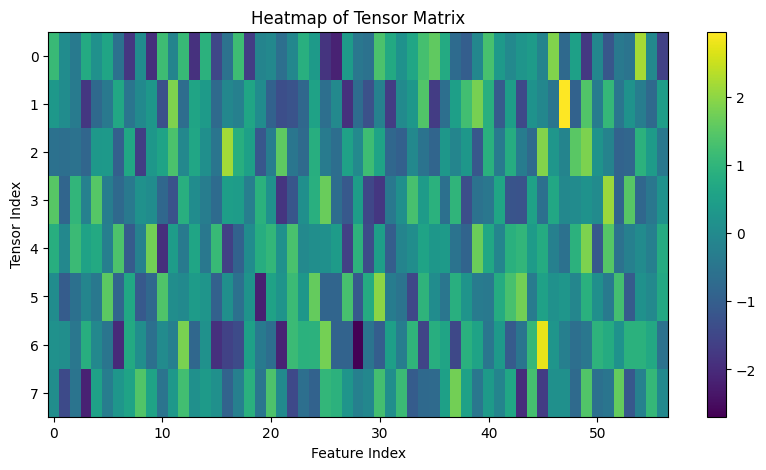

In [19]:
import torch
import matplotlib.pyplot as plt

# Example list of tensors, each with shape [1, 57]
tensor_list = [torch.randn(1, 57) for _ in range(8)]

# Stack tensors along a new dimension to form a matrix of shape [8, 57]
matrix = torch.cat(tensor_list, dim=0)

# Visualize the matrix as a heatmap
plt.figure(figsize=(10, 5))  # Set figure size
plt.imshow(matrix, aspect='auto', cmap='viridis')  # Display data as an image, i.e., on a 2D regular raster
plt.colorbar()  # Add a colorbar to a plot
plt.title('Heatmap of Tensor Matrix')
plt.xlabel('Feature Index')
plt.ylabel('Tensor Index')
plt.show()

## 2.2 Heatmaps of INCONSISTENT color scales

In [1]:
import os

data_dir = "../data"
mmlu_data_dir = os.path.join(data_dir, "eval", "mmlu")
subjects = sorted(
    [
        f.split("_test.csv")[0]
        for f in os.listdir(os.path.join(mmlu_data_dir, "test"))
        if "_test.csv" in f
    ]
)

print(subjects)
print(len(subjects))

['abstract_algebra', 'anatomy', 'astronomy', 'business_ethics', 'clinical_knowledge', 'college_biology', 'college_chemistry', 'college_computer_science', 'college_mathematics', 'college_medicine', 'college_physics', 'computer_security', 'conceptual_physics', 'econometrics', 'electrical_engineering', 'elementary_mathematics', 'formal_logic', 'global_facts', 'high_school_biology', 'high_school_chemistry', 'high_school_computer_science', 'high_school_european_history', 'high_school_geography', 'high_school_government_and_politics', 'high_school_macroeconomics', 'high_school_mathematics', 'high_school_microeconomics', 'high_school_physics', 'high_school_psychology', 'high_school_statistics', 'high_school_us_history', 'high_school_world_history', 'human_aging', 'human_sexuality', 'international_law', 'jurisprudence', 'logical_fallacies', 'machine_learning', 'management', 'marketing', 'medical_genetics', 'miscellaneous', 'moral_disputes', 'moral_scenarios', 'nutrition', 'philosophy', 'prehis

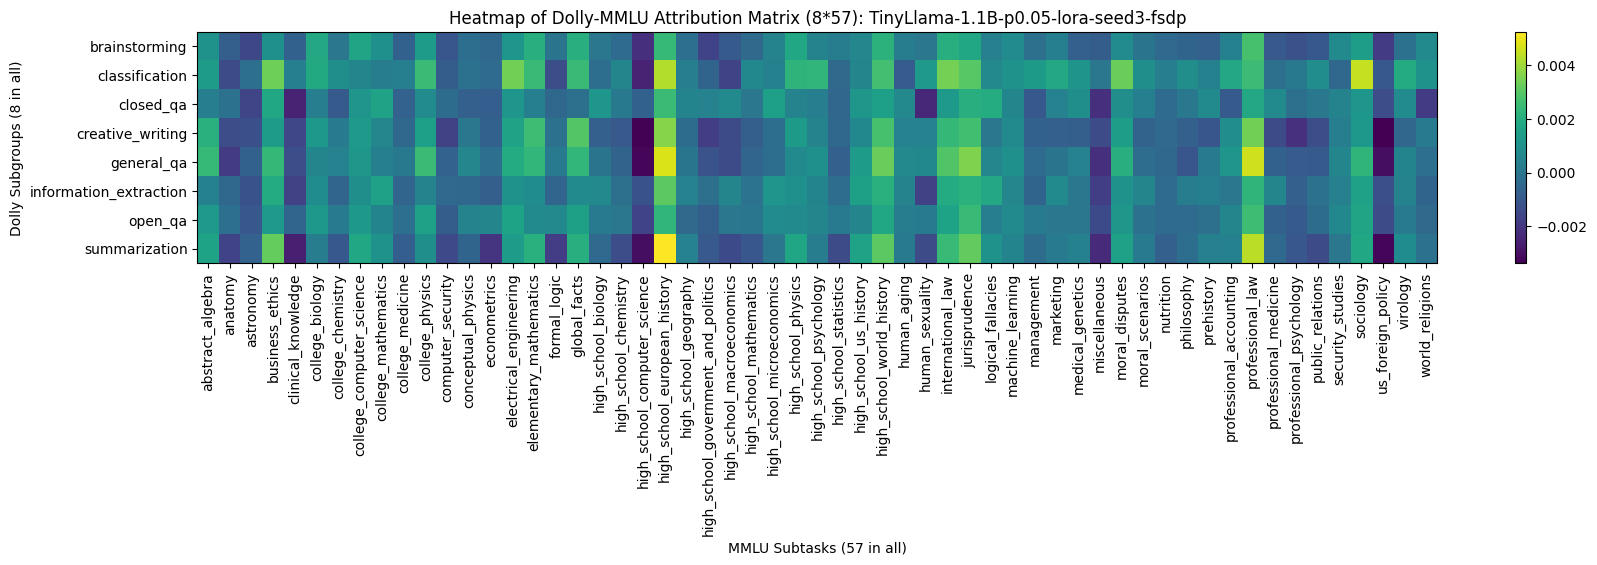

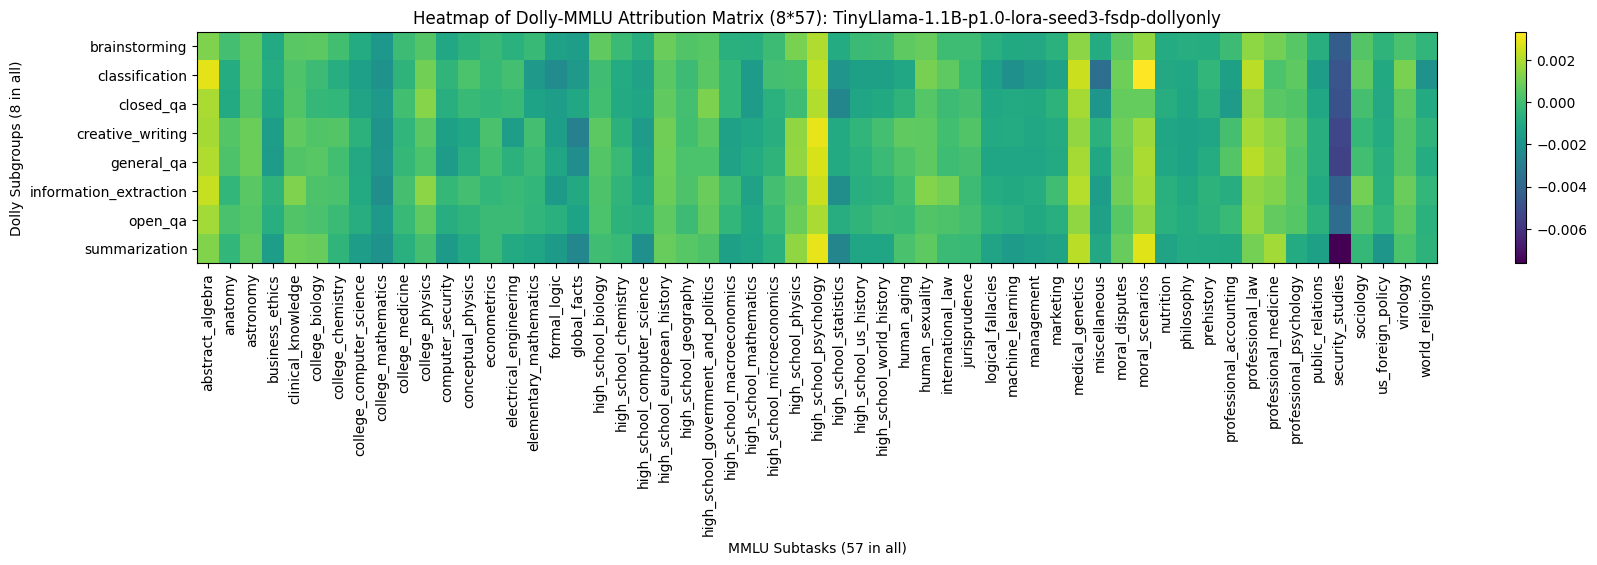

In [16]:
import torch
import matplotlib.pyplot as plt

# Define column and row labels
column_labels = subjects
row_labels = ["summarization", "brainstorming", "closed_qa", "creative_writing", "information_extraction", "classification", "open_qa", "general_qa"]
row_labels.sort()

# reference_model = "TinyLlama-1.1B-p0.05-lora-seed3-fsdp"
# reference_model = "TinyLlama-1.1B-p1.0-lora-seed3-fsdp-dollyonly"
model_list = [
    "TinyLlama-1.1B-p0.05-lora-seed3-fsdp",
    "TinyLlama-1.1B-p1.0-lora-seed3-fsdp-dollyonly",
]


def plot_heatmap(reference_model, row_labels, column_labels):
    row_list = []
    for subset in row_labels:
        matpath = f"../attribution_matrix/{reference_model}/mmlu/{subset}_attribution_matrix.pt"
        mat = torch.load(matpath)
        assert mat.shape == torch.Size([1, 57])
        row_list.append(mat)
    assert len(row_list) == 8, f"{len(row_list)}"

    device = "cpu"
    attribution_matrix = torch.cat(row_list, dim=0).to(device)

    # Visualize the matrix as a heatmap
    plt.figure(figsize=(20, 3))  # Adjusted figure size for better visibility
    heatmap = plt.imshow(attribution_matrix, aspect='auto', cmap='viridis')
    plt.colorbar(heatmap)
    plt.title(f"Heatmap of Dolly-MMLU Attribution Matrix (8*57): {reference_model}")
    plt.xlabel('MMLU Subtasks (57 in all)')
    plt.ylabel('Dolly Subgroups (8 in all)')

    # Setting the ticks
    plt.xticks(ticks=range(len(column_labels)), labels=column_labels, rotation=90)  # Rotate column labels for better visibility
    plt.yticks(ticks=range(len(row_labels)), labels=row_labels)

    plt.show()


for reference_model in model_list:
    plot_heatmap(reference_model, row_labels, column_labels)

## 2.3 Heatmaps of CONSISTENT color scales

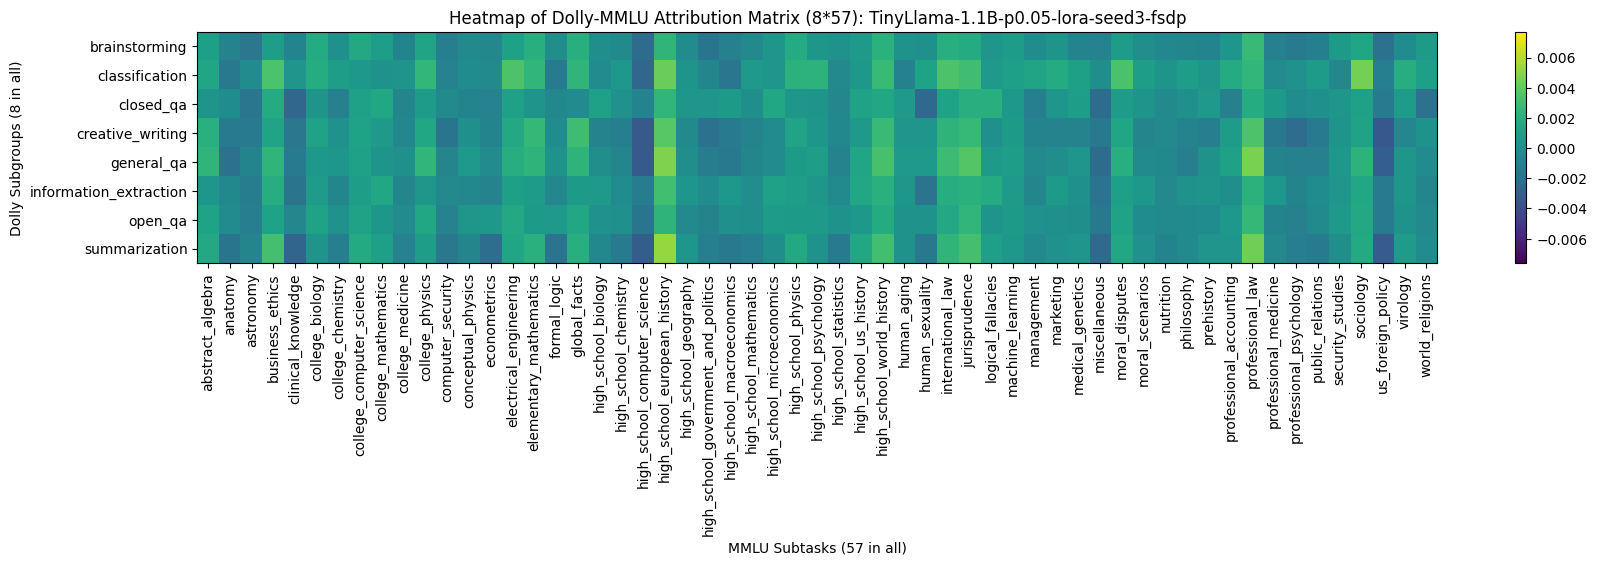

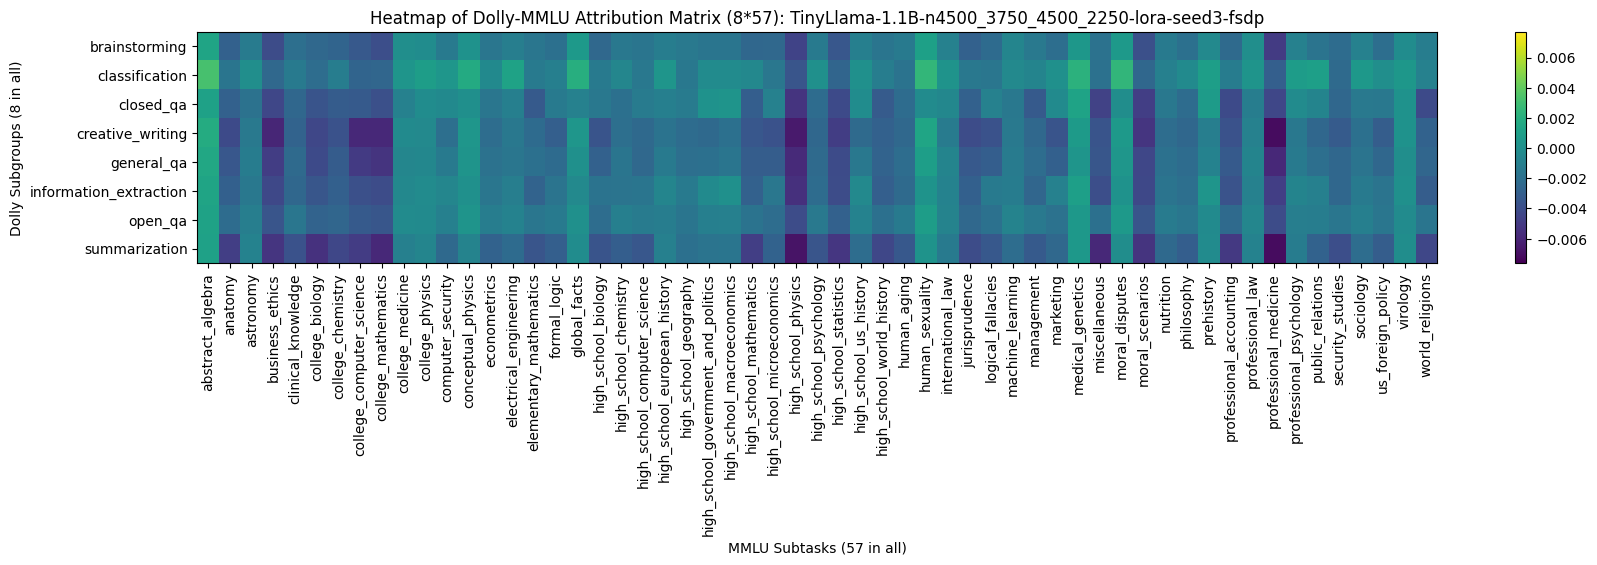

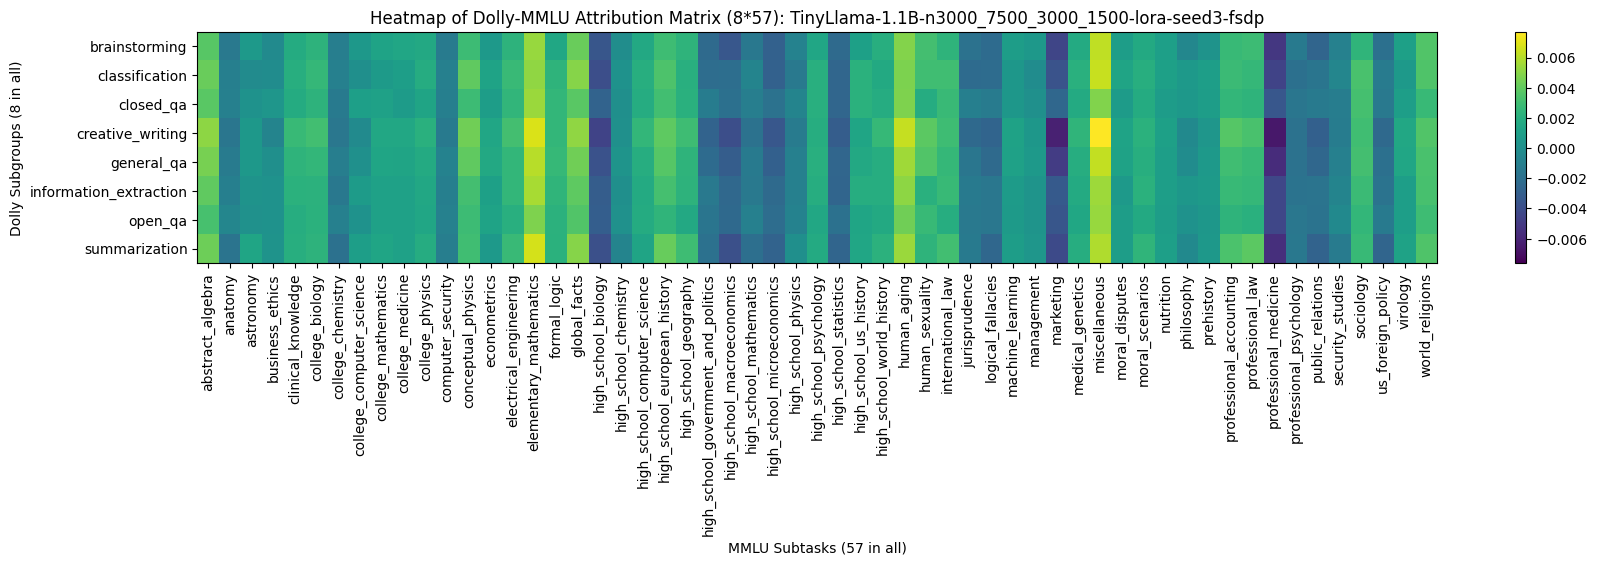

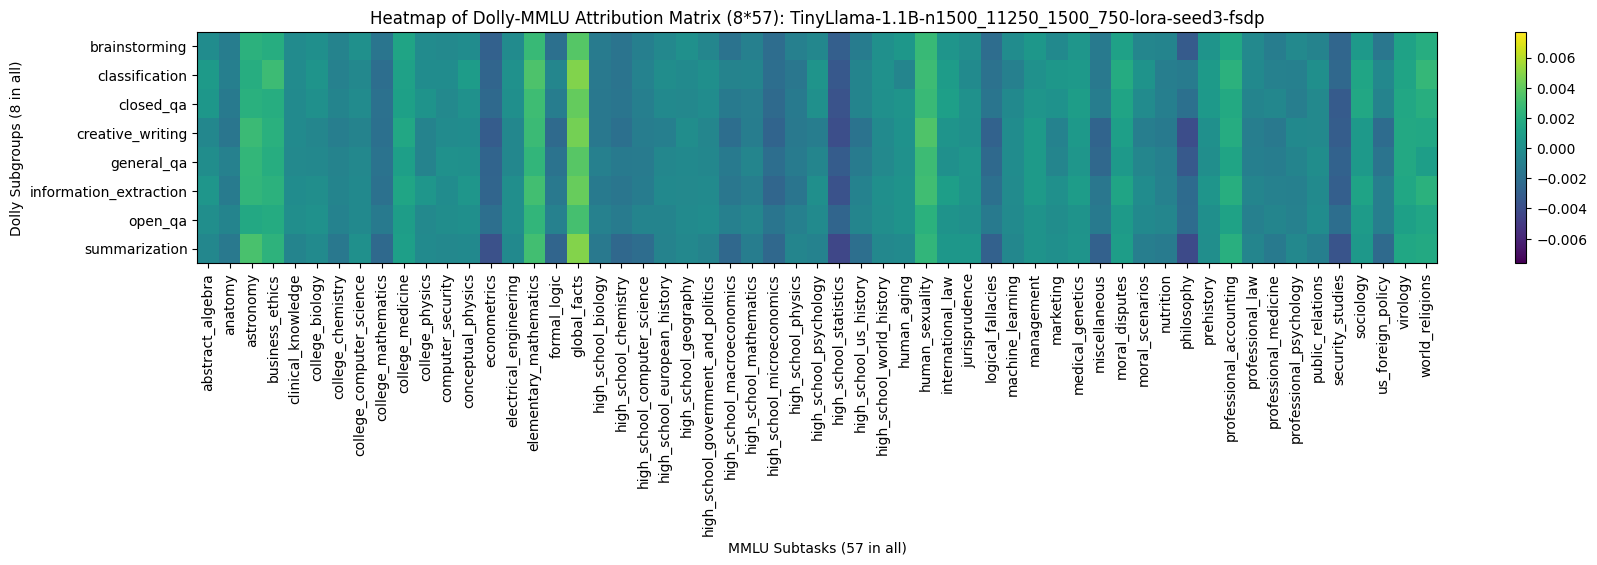

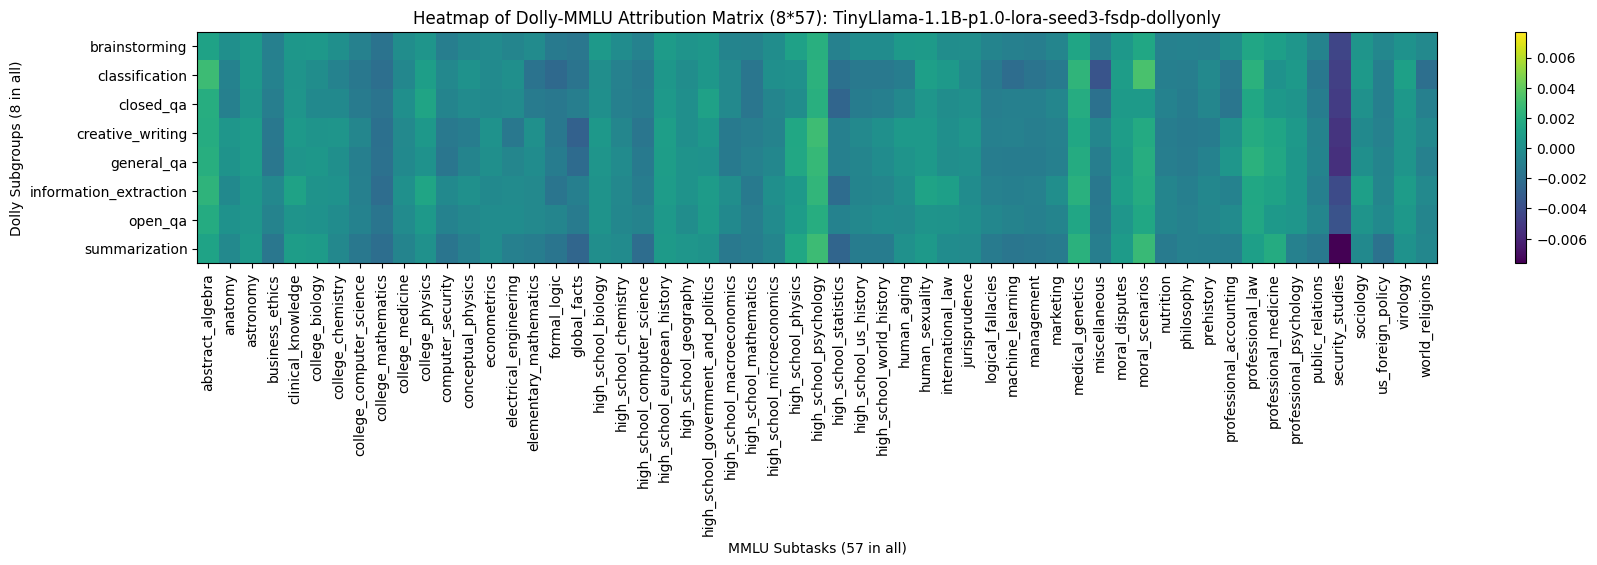

In [3]:
import torch
import matplotlib.pyplot as plt
import os

# obtain the names of all 57 subjects in mmlu
data_dir = "../data"
mmlu_data_dir = os.path.join(data_dir, "eval", "mmlu")
subjects = sorted(
    [
        f.split("_test.csv")[0]
        for f in os.listdir(os.path.join(mmlu_data_dir, "test"))
        if "_test.csv" in f
    ]
)

# Define column and row labels
column_labels = subjects
row_labels = ["summarization", "brainstorming", "closed_qa", "creative_writing", "information_extraction", "classification", "open_qa", "general_qa"]
row_labels.sort()

model_list = [
    "TinyLlama-1.1B-p0.05-lora-seed3-fsdp",
    "TinyLlama-1.1B-n4500_3750_4500_2250-lora-seed3-fsdp",
    "TinyLlama-1.1B-n3000_7500_3000_1500-lora-seed3-fsdp",
    "TinyLlama-1.1B-n1500_11250_1500_750-lora-seed3-fsdp",
    "TinyLlama-1.1B-p1.0-lora-seed3-fsdp-dollyonly",
]


def global_min_max(model_list, row_labels):
    global_min, global_max = float('inf'), float('-inf')
    for reference_model in model_list:
        row_list = []
        for subset in row_labels:
            matpath = f"../attribution_matrix/{reference_model}/mmlu/{subset}_attribution_matrix.pt"
            mat = torch.load(matpath)
            assert mat.shape == torch.Size([1, 57])
            row_list.append(mat)
        assert len(row_list) == 8, f"{len(row_list)}"

        attribution_matrix = torch.cat(row_list, dim=0)
        min_val = torch.min(attribution_matrix)
        max_val = torch.max(attribution_matrix)
        global_min = min(global_min, min_val)
        global_max = max(global_max, max_val)
    return global_min.item(), global_max.item()


def plot_heatmap(reference_model, row_labels, column_labels, vmin, vmax):
    row_list = []
    for subset in row_labels:
        matpath = f"../attribution_matrix/{reference_model}/mmlu/{subset}_attribution_matrix.pt"
        mat = torch.load(matpath)
        assert mat.shape == torch.Size([1, 57])
        row_list.append(mat)
    assert len(row_list) == 8, f"{len(row_list)}"

    device = "cpu"
    attribution_matrix = torch.cat(row_list, dim=0).to(device)

    plt.figure(figsize=(20, 3))
    heatmap = plt.imshow(attribution_matrix, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
    plt.colorbar(heatmap)
    plt.title(f"Heatmap of Dolly-MMLU Attribution Matrix (8*57): {reference_model}")
    plt.xlabel('MMLU Subtasks (57 in all)')
    plt.ylabel('Dolly Subgroups (8 in all)')
    plt.xticks(ticks=range(len(column_labels)), labels=column_labels, rotation=90)
    plt.yticks(ticks=range(len(row_labels)), labels=row_labels)
    plt.show()


# First, find the global minimum and maximum values
vmin, vmax = global_min_max(model_list, row_labels)

# Now plot each heatmap with the same color scale
for reference_model in model_list:
    plot_heatmap(reference_model, row_labels, column_labels, vmin, vmax)

# 3. Load and compare original `dolly-15k` dataset

In [ ]:
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
from datasets import load_dataset
cache_dir = '/root/autodl-tmp/huggingface/datasets'

# Ensure the cache directory exists
os.makedirs(cache_dir, exist_ok=True)

# Load the dataset from the specified mirror and cache it in the custom directory
dataset = load_dataset('databricks/databricks-dolly-15k', cache_dir=cache_dir)

## 3.1 Classify `dolly_data.jsonl` into 8 subsets

In [14]:
from datasets import load_dataset
import json


cache_dir = '/root/autodl-tmp/huggingface/datasets'
dataset_name_or_path = 'databricks/databricks-dolly-15k'

dataset = load_dataset(dataset_name_or_path, cache_dir=cache_dir)
dataset = dataset["train"]
categories = dataset["category"]

processed_path = "../data/train/processed/dolly/dolly_data.jsonl"

classified_dict = {}
with open(processed_path, 'r') as f:
    lines = f.readlines()
for idx, line in enumerate(lines):
    jsondict = json.loads(line)
    assert idx == int(jsondict["id"].split("dolly_")[-1]), print(idx)

    cat = categories[idx]
    assert type(cat) == str
    if classified_dict.get(cat, None) == None:
        classified_dict[cat] = []
    classified_dict[cat].append(jsondict)

assert len(classified_dict) == 8


def write_subset_jsonl(category, json_list):
    outpath = f"../data/train/processed/dolly/dolly_data_{category}.jsonl"
    with open(outpath, 'w') as f:
        for json_dict in json_list:
            json.dump(json_dict, f)
            f.write('\n')   # Write a newline to separate JSON objects


for cat, lst in classified_dict.items():
    write_subset_jsonl(cat, lst)

Using the latest cached version of the dataset since databricks/databricks-dolly-15k couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/autodl-tmp/huggingface/datasets/databricks___databricks-dolly-15k/default/0.0.0/bdd27f4d94b9c1f951818a7da7fd7aeea5dbff1a (last modified on Thu May 23 20:21:17 2024).


In [15]:
cate_set = set(categories)
assert len(cate_set) == 8
print(cate_set)

{'summarization', 'brainstorming', 'closed_qa', 'creative_writing', 'information_extraction', 'classification', 'open_qa', 'general_qa'}


In [12]:
import json

# Your list of dictionaries
data = [
    {'name': 'Alice', 'age': 25},
    {'name': 'Bob', 'age': 30},
    {'name': 'Charlie', 'age': 35}
]

# Writing the list to a .jsonl file
with open('data.jsonl', 'w') as file:
    for entry in data:
        json.dump(entry, file)
        file.write('\n')  # Write a newline to separate JSON objects

# 4. View the .pkl `aux_data` in Skill-it

In [1]:
import pickle

# Replace 'file.pkl' with the path to your .pkl file
pkl_path = f"../skill-it/aux_data/ni_xlingual_task_info.pkl"
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)

print(data)

          task                         source               task_category  \
0      task512                        emotion          sentiment_analysis   
1      task609                           sbic    toxic_language_detection   
2      task025                       cosmosqa  wrong_candidate_generation   
3      task518                            emo          sentiment_analysis   
4      task227                         clariq      question_understanding   
...        ...                            ...                         ...   
1265  task1383                         quarel  wrong_candidate_generation   
1266  task1190                      synthetic           program_execution   
1267  task1207                         atomic  commonsense_classification   
1268   task561        asian_language_treebank                 translation   
1269  task1645  medical_question_pair_dataset               text_matching   

                                                 domain input_language  \
0

# 5. Extract the most/least influential training point for each subtask

In [ ]:
import json
import torch